# Drug Repurposing through Content-based Collaborative Filtering

Given a binary dataframe of ligand-receptor interactions, predict whether a ligand will bind to a receptor. The setup of this task is similar to that of movie or song recommendations for Netflix or Spotify users. Note that the ideal formalation of this problem is to have a complete set of ligand-receptor interactions and absence of interaction; however, we only have a set of interactions. We do not have a set of negative results. For simplicity sake, we will assume that absence of evidence is evidence of absence. 

**Dataset:** We have an "edgelist" of G-protein coupled receptor (GPCR) and Ligands (gpcr.csv) that was scraped from (https://www.guidetopharmacology.org/GRAC/GPCRListForward?class=A) using the Scraper_GuideToPharmacology.ipynb.

**Preprocessing:** The edgelist contains both antagonists and agonists, so we will first split the edgelist into two subsets of edgelists that we will then individually convert into separate dataframes (receptors x ligand) where 1 indicates ligand-receptor interaction and NaN otherwise. 
1. Split edgelist into agonists and antagonists
2. Build dataframes from each edgelist

**Processing:** For testing purposes, we will "mask out" equal numbers of positive and negative examples - storing them in a held-out testing set
1. Mask out positive and negative examples: add them to held-out test set


**Collaborative Filtering:** Given each entry in our testing set, predict whether the interaction is likely to occur (1 or 0).
1. Femporarily remove the ligand (column) from the dataframe
2. For receptor (row), impute NaN using 0.5
3. Correlate each row with the row of our entry
4. Weights are computed using the square of the correlation: constrains between 0 and 1
5. The ligand values of each row is weighted by the weights 
6. The weighted values are aggregated and normalized to between 0 and 1
7. We apply a linear decision boundary


In [352]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, sys
import pickle
sys.path.insert(0, '../../../precidiag')
from precidiag.preprocessing import Word2Vec


# Step 1. Preprocessing dataset

### Open edgelist and split edgelist into agonists and antagonists

In [353]:
dataframe = pd.read_csv('gpcr.csv')
dataframe.head()

,Name,ID,Ligand,Action,Value,Parameter,Uniprot,Class
0,5-HT1Areceptor,3925,[3H]NLX-112,Fullagonist,8.9,pKd,P08908,agonists
1,5-HT1Areceptor,31,[3H]8-OH-DPAT,Fullagonist,6.0–9.4,pKd,P08908,agonists
2,5-HT1Areceptor,32,[3H]S-15535,Partialagonist,5.8–5.9,pKd,P08908,agonists
3,5-HT1Areceptor,25,S-14671,Fullagonist,10.2–10.5,pKi,P08908,agonists
4,5-HT1Areceptor,19,LY293284,Fullagonist,10.1,pKi,P08908,agonists


In [368]:
classes = ['agonists', 'antagonists']

edgelists = {}
for class_ in classes:
    edgelists[class_] = dataframe[dataframe['Class'] == class_]

### Build dataframes from each edgelist

In [373]:
def build_dataframe(edgelist, receptor_column = 'Uniprot', ligand_column = 'ID'):
    receptors, ligands = edgelist[receptor_column].unique(), edgelist[ligand_column].unique()
    df = pd.DataFrame(np.zeros((len(receptors), len(ligands))), index = receptors, columns = ligands)
    
    for i, edge in edgelist.iterrows():
        df.loc[edge[receptor_column], edge[ligand_column]] = 1
               
    df.replace(0, np.nan, inplace = True)
    return df

ground_truth = {class_: build_dataframe(df) for class_, df in edgelists.items()}

In [500]:
def impute_nan(df): 
    means = df.sum(axis = 1) / df.shape[1]
    return df.T.fillna(value = means).T

temp = {class_:impute_nan(df) for class_, df in ground_truth.items()} 

In [527]:
df = temp['agonists'].copy()
df

,3925,31,32,25,19,4,43,30,7427,24,...,1407,1408,6411,6421,3421,1417,1436,3359,1438,1443
P08908,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.040488,0.040488,0.040488,0.040488,0.040488,0.040488,0.040488,0.040488,0.040488,0.040488
P28222,0.031614,1.000000,0.031614,0.031614,0.031614,1.000000,1.000000,0.031614,0.031614,0.031614,...,0.031614,0.031614,0.031614,0.031614,0.031614,0.031614,0.031614,0.031614,0.031614,0.031614
P28221,0.032169,1.000000,0.032169,0.032169,0.032169,1.000000,1.000000,0.032169,0.032169,0.032169,...,0.032169,0.032169,0.032169,0.032169,0.032169,0.032169,0.032169,0.032169,0.032169,0.032169
P28566,0.019412,0.019412,0.019412,0.019412,0.019412,1.000000,0.019412,0.019412,0.019412,0.019412,...,0.019412,0.019412,0.019412,0.019412,0.019412,0.019412,0.019412,0.019412,0.019412,0.019412
P30939,0.018303,0.018303,0.018303,0.018303,0.018303,1.000000,0.018303,0.018303,0.018303,0.018303,...,0.018303,0.018303,0.018303,0.018303,0.018303,0.018303,0.018303,0.018303,0.018303,0.018303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q14833,0.006101,0.006101,0.006101,0.006101,0.006101,0.006101,0.006101,0.006101,0.006101,0.006101,...,1.000000,1.000000,0.006101,0.006101,0.006101,0.006101,0.006101,0.006101,0.006101,0.006101
P41594,0.006101,0.006101,0.006101,0.006101,0.006101,0.006101,0.006101,0.006101,0.006101,0.006101,...,0.006101,0.006101,1.000000,1.000000,1.000000,1.000000,0.006101,0.006101,0.006101,0.006101
O15303,0.007765,0.007765,0.007765,0.007765,0.007765,0.007765,0.007765,0.007765,0.007765,0.007765,...,1.000000,1.000000,0.007765,0.007765,0.007765,0.007765,1.000000,1.000000,0.007765,0.007765
Q14831,0.004992,0.004992,0.004992,0.004992,0.004992,0.004992,0.004992,0.004992,0.004992,0.004992,...,0.004992,0.004992,0.004992,0.004992,0.004992,0.004992,0.004992,0.004992,1.000000,0.004992


In [542]:
df = temp['agonists'].copy()
for iteration in range(5):
    print(iteration)
    t = df.copy()
    for row_name, row in df.iterrows():

        weights = df.corrwith(row, axis = 1) ** 2
        weights.loc[row_name] = np.nan
        weights /= weights.sum()
        weights.loc[row_name] = 0

        t.loc[row_name] = df.multiply(weights, axis = 0).sum(axis = 0)
    df = t.copy()

0
1
2
3
4


In [543]:
df

,3925,31,32,25,19,4,43,30,7427,24,...,1407,1408,6411,6421,3421,1417,1436,3359,1438,1443
P08908,0.043674,0.111397,0.043674,0.043674,0.043674,0.311718,0.267701,0.043674,0.063668,0.043674,...,0.024607,0.024607,0.019320,0.019320,0.019320,0.019320,0.019965,0.019965,0.018926,0.019341
P28222,0.043674,0.111397,0.043674,0.043674,0.043674,0.311718,0.267701,0.043674,0.063668,0.043674,...,0.024607,0.024607,0.019320,0.019320,0.019320,0.019320,0.019965,0.019965,0.018926,0.019341
P28221,0.043674,0.111397,0.043674,0.043674,0.043674,0.311718,0.267701,0.043674,0.063668,0.043674,...,0.024607,0.024607,0.019320,0.019320,0.019320,0.019320,0.019965,0.019965,0.018926,0.019341
P28566,0.043674,0.111397,0.043674,0.043674,0.043674,0.311718,0.267701,0.043674,0.063668,0.043674,...,0.024607,0.024607,0.019320,0.019320,0.019320,0.019320,0.019965,0.019965,0.018926,0.019341
P30939,0.043674,0.111397,0.043674,0.043674,0.043674,0.311718,0.267701,0.043674,0.063668,0.043674,...,0.024607,0.024607,0.019320,0.019320,0.019320,0.019320,0.019965,0.019965,0.018926,0.019341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q14833,0.006653,0.007762,0.006653,0.006653,0.006653,0.010962,0.010383,0.006653,0.007157,0.006653,...,0.437360,0.437360,0.092376,0.092376,0.092376,0.092376,0.169737,0.169737,0.142324,0.153251
P41594,0.006652,0.007763,0.006652,0.006652,0.006652,0.010963,0.010384,0.006652,0.007157,0.006652,...,0.437372,0.437372,0.092266,0.092266,0.092266,0.092266,0.169695,0.169695,0.142274,0.153192
O15303,0.006652,0.007760,0.006652,0.006652,0.006652,0.010956,0.010378,0.006652,0.007155,0.006652,...,0.437333,0.437333,0.092376,0.092376,0.092376,0.092376,0.169594,0.169594,0.142306,0.153229
Q14831,0.006650,0.007755,0.006650,0.006650,0.006650,0.010940,0.010364,0.006650,0.007152,0.006650,...,0.437477,0.437477,0.092394,0.092394,0.092394,0.092394,0.169740,0.169740,0.142189,0.153211


In [ ]:
test = antagonists_test.copy()
df = antagonists.copy()
for i, test in enumerate(test):

    entry = df.index[test[0]], df.columns[test[1]]
    temp = df.copy()

    # removed column
    temp = temp.loc[:, temp.columns != entry[1]]

    # impute values
    means = temp.sum(axis = 1) / temp.shape[1]
    temp = temp.T.fillna(value = means).T

    # corr**2 and standardize
    weights = temp.corrwith(temp.loc[entry[0]], axis = 1) ** 2
    weights = weights / weights.sum()

    values = df.fillna(0).loc[:, entry[1]]
    prediction = (values * weights).sum()

    print(i, prediction, int(prediction > threshold))

In [405]:
ground_truth['agonists']

,3925,31,32,25,19,4,43,30,7427,24,...,1407,1408,6411,6421,3421,1417,1436,3359,1438,1443
P08908,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P28222,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P28221,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P28566,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P30939,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q14833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P41594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
O15303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
Q14831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


### Get unique receptors and ligands

In [342]:
unique_receptors, unique_ligands = dataframe['Uniprot'].unique(), dataframe['ID'].unique()
unique_receptors.size, unique_ligands.size

(180, 3213)


### Build dataframe of receptor x ligand

In [343]:
def build_dataframe(dataframe):
    # building edgelist
    receptors, ligands = dataframe['Uniprot'].unique(), dataframe['ID'].unique()
    
    df = pd.DataFrame(np.zeros((len(receptors), len(ligands))))
    df.index = receptors
    df.columns = ligands

    for i, edge in dataframe.iterrows():
        df.loc[edge['Uniprot'], edge['ID']] = 1      

    return df
        
antagonists = build_dataframe(dataframe[dataframe['Class'] == 'antagonists'])
agonists =  build_dataframe(dataframe[dataframe['Class'] == 'agonists'])

### Zero mask select entries and add them to testing set

In [344]:
test_size = 0.3

In [345]:
def mask_dataframe(df):
    # zero mask entries and add them to testing set
    sample = 0
    drop_elements = []

    index = np.argwhere(df.values > 0)
    np.random.shuffle(index)
    for i in index:
        if df.iloc[i[0]].sum() > 1 and df.iloc[:, i[1]].sum() > 1:
            df.iloc[i[0], i[1]] = 0
            drop_elements.append(i)
            sample += 1
        if sample >= int(test_size * df.shape[0]):
            break
    return [list(a) for a in drop_elements], df

antagonists_test, antagonists = mask_dataframe(antagonists)
agonists_test, agonists = mask_dataframe(agonists)
antagonists.shape, agonists.shape

((180, 1518), (180, 1803))

### Embedd receptors and ligands using Word2Vec

In [346]:
# embedd ligands and receptors
# Note: potential problem, word2vec drops features

word2vec = lambda df: Word2Vec(vector_size = 100, min_count = 0, window = df.shape[0]).fit_transform(df)

antagonists_vector = word2vec(antagonists)
agonists_vector = word2vec(agonists)
receptors_vector = word2vec(pd.concat([antagonists, agonists], axis = 1).T)


### Given edgelist, build training and testing data

In [347]:
def get_negatives(df, drop_elements):
    negative_indices = np.argwhere(df.values == 0)
    np.random.shuffle(negative_indices)
    
    negative_samples = []
    for negative_index in negative_indices:
        if list(negative_index) not in drop_elements:
            negative_samples.append([negative_index[0], negative_index[1]])
#            negative_samples.append([df.columns[negative_index[1]], df.index[negative_index[0]]])
        if len(negative_samples) >= df.sum().sum(): 
            break
            
    return negative_samples

antagonists_negatives = get_negatives(antagonists, antagonists_test)
agonists_negatives = get_negatives(agonists, agonists_test)

In [348]:
df = agonists.copy()
ligands = agonists_vector.copy()
receptors = receptors_vector.copy()

def format_data(edgelist, ligands, receptors):
    x = np.zeros((len(edgelist), ligands.shape[1] + receptors.shape[1]))

    for i, (receptor_index, ligand_index) in enumerate(edgelist):
        ligand = ligands.iloc[ligand_index]
        receptor = receptors.iloc[receptor_index]
        x[i] = np.append(ligand.values, receptor.values)

    y = np.ones(x.shape[0])
    return x, y

def get_data(df, negatives, vector):
    positive_x, positive_y = format_data(np.argwhere(df.values == 1), vector.copy(), receptors_vector)
    negative_x, negative_y = format_data(negatives, vector.copy(), receptors_vector)
    negative_y *= 0 # set to 0
    x = np.vstack([positive_x, negative_x])
    y = np.append(positive_y, negative_y)
        
        
    return x, y

x, y = get_data(agonists, agonists_negatives, agonists_vector)
agonist_xtrain, agonist_xtest, agonist_ytrain, agonist_ytest = train_test_split(x, y, test_size = test_size, stratify = y)

x, y = get_data(antagonists, antagonists_negatives, antagonists_vector)
antagonist_xtrain, antagonist_xtest, antagonist_ytrain, antagonist_ytest = train_test_split(x, y, test_size = test_size, stratify = y)



# model fitting 

In [97]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
"""
models = {
    'antagonist': GradientBoostingClassifier(),
    'agonist': GradientBoostingClassifier()
}
for model_name, model in models.items():
    model.fit()"""

In [99]:
antagonist_model = GradientBoostingClassifier()
agonist_model = GradientBoostingClassifier()

antagonist_model.fit(antagonist_xtrain, antagonist_ytrain)
agonist_model.fit(agonist_xtrain, agonist_ytrain)

GradientBoostingClassifier()

In [100]:
antagonist_model.score(antagonist_xtest, antagonist_ytest)

0.6939163498098859

In [101]:
antagonist_model.score(agonist_xtest, agonist_ytest)

0.5772357723577236

### Test on held out set
## (TODO)

In [ ]:
test_y = np.ones(len(drop_elements))
test_y.shape

In [ ]:
test_x = np.zeros((test_y.size, receptors.shape[1] + ligands.shape[1]))
exception = []
for i, edge in enumerate(drop_elements):
    try:
        test_x[i] = np.append(ligands.loc[edge[0]], receptors.loc[edge[1]])
        exception.append(i)
    except Exception as e:
        continue
test_x, test_y = test_x[exception], test_y[exception]

In [ ]:
model.score(test_x, test_y), test_y.mean(), test_y.shape

# Collaborative Filtering works REALLY fucking well

In [349]:
threshold = 0.1
test = antagonists_test[5]
#test = antagonists_negatives[0]

antagonists.replace(0, np.nan, inplace = True)
entry = antagonists.index[test[0]], antagonists.columns[test[1]]
entry

('P08588', 532)

In [ ]:
agonists

In [351]:
test = antagonists_test.copy()
df = antagonists.copy()
for i, test in enumerate(test):

    entry = df.index[test[0]], df.columns[test[1]]
    temp = df.copy()

    # removed column
    temp = temp.loc[:, temp.columns != entry[1]]

    # impute values
    means = temp.sum(axis = 1) / temp.shape[1]
    temp = temp.T.fillna(value = means).T

    # corr**2 and standardize
    weights = temp.corrwith(temp.loc[entry[0]], axis = 1) ** 2
    weights = weights / weights.sum()

    values = df.fillna(0).loc[:, entry[1]]
    prediction = (values * weights).sum()

    print(i, prediction, int(prediction > threshold))

0 0.3108094920223975 1
1 0.5015452702652479 1
2 0.2987481103993115 1
3 0.26669288578210404 1
4 0.05614080937958123 0
5 0.2735638574986673 1
6 0.2074810877924575 1
7 0.2681203424824288 1
8 0.7214434427125007 1
9 0.17089469986553812 1
10 0.30848135991237097 1
11 2.8215077736517246e-05 0
12 0.683447977070498 1
13 0.12111711710247498 1
14 0.7332617223417219 1
15 0.16613764916823776 1
16 0.48188616602552636 1
17 0.5536294223330305 1
18 0.22920468238363792 1
19 0.03938629460923279 0
20 0.5154354789718707 1
21 0.09121915488189185 0
22 0.5642820088109529 1
23 0.00015446134297498402 0
24 0.09243943078125569 0
25 0.33633877888086666 1
26 0.27356385749866746 1
27 0.15722891125205085 1
28 0.3744292614089402 1
29 0.5449046606392627 1
30 0.4630326299965635 1
31 0.12111711710247498 1
32 0.7305741091069161 1
33 0.19218134018427271 1
34 0.5187213629460622 1
35 0.2457688679677996 1
36 0.43995916277353675 1
37 0.23708562840706676 1
38 0.5293568587586605 1
39 0.3574050885188479 1
40 0.1794061562809441 1
4

In [243]:
temp = antagonists[antagonists.loc[:, entry[1]] == 1]

weights = antagonists.corrwith(antagonists.loc[entry[0]], axis = 1)
weights 

P08908    0.146364
P28222    0.388631
P28221    0.375460
P28566    0.815414
P30939    1.000000
            ...   
Q14833   -0.003741
P41594   -0.005298
O15303   -0.004184
Q14831   -0.005298
O00222   -0.004585
Length: 180, dtype: float64

In [242]:
temp.loc[:, entry[1]]

P08908    1.0
P28222    1.0
P28221    1.0
P28566    1.0
P28223    1.0
P28335    1.0
P50406    1.0
P34969    1.0
P18089    1.0
P35462    1.0
P21917    1.0
P35367    1.0
Name: 103, dtype: float64

In [232]:
temp = antagonists[antagonists.loc[:, entry[1]] == 1]

weights = temp.corrwith(antagonists.loc[entry[0]], axis = 1)
weights /= weights.sum()
values = temp.loc[:, entry[1]]

weighted_values = weights * values
prediction = weighted_values.sum() > threshold

prediction

True

In [211]:
values

P08908    1.0
P28222    1.0
P28221    1.0
P28566    1.0
P28223    1.0
P28335    1.0
P50406    1.0
P34969    1.0
P18089    1.0
P35462    1.0
P21917    1.0
P35367    1.0
Name: 103, dtype: float64

## Fun stuff: visualizations

In [102]:
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

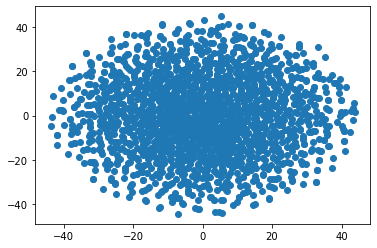

In [109]:
temp = TSNE(n_components = 2).fit_transform(agonists_vector)

plt.scatter(temp[:, 0], temp[:, 1])

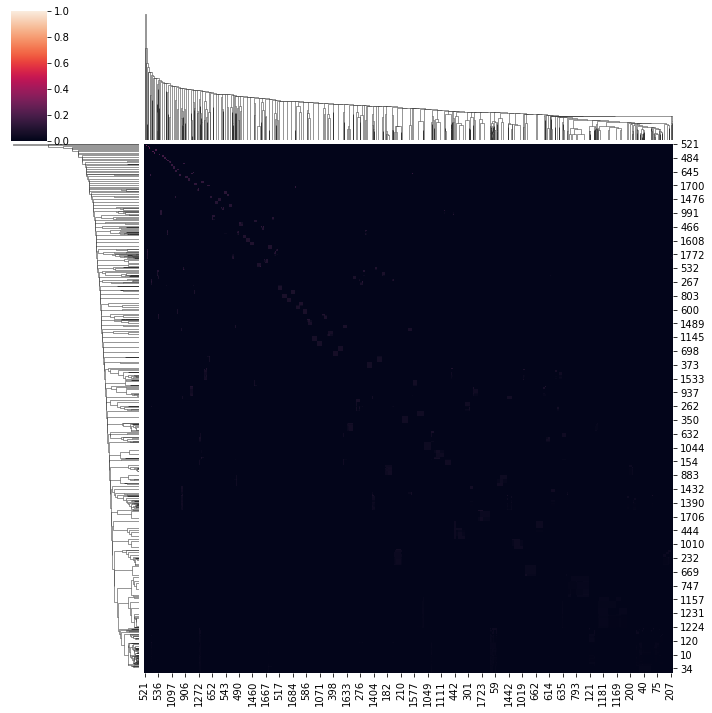

In [138]:
temp = np.dot(agonists.T, agonists)
temp /= temp.sum(axis = 1)[:,None]
sns.clustermap(temp)

/home/erxw/anaconda3/envs/discoverx/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


(1518, 1518)

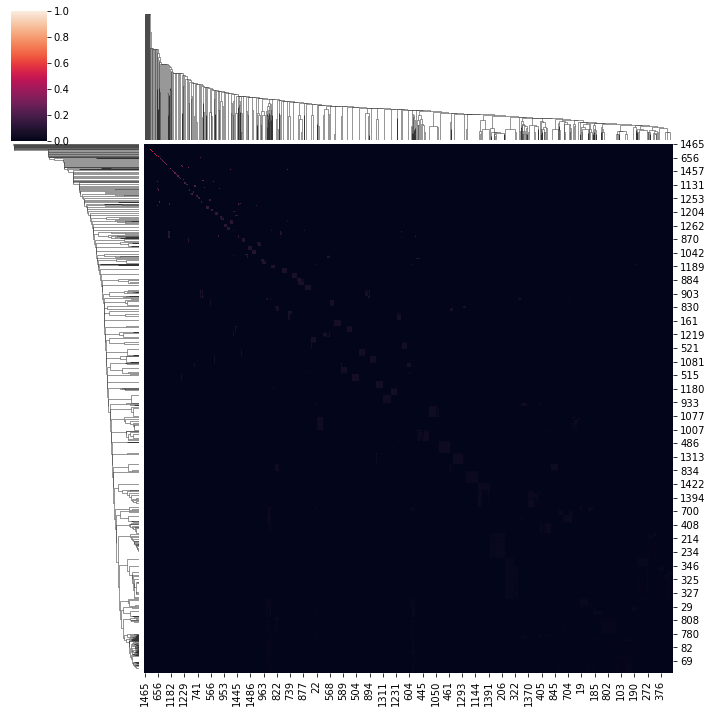

In [137]:
temp = np.dot(antagonists.T, antagonists)
temp /= temp.sum(axis = 1)[:,None]
sns.clustermap(temp)
temp.shape

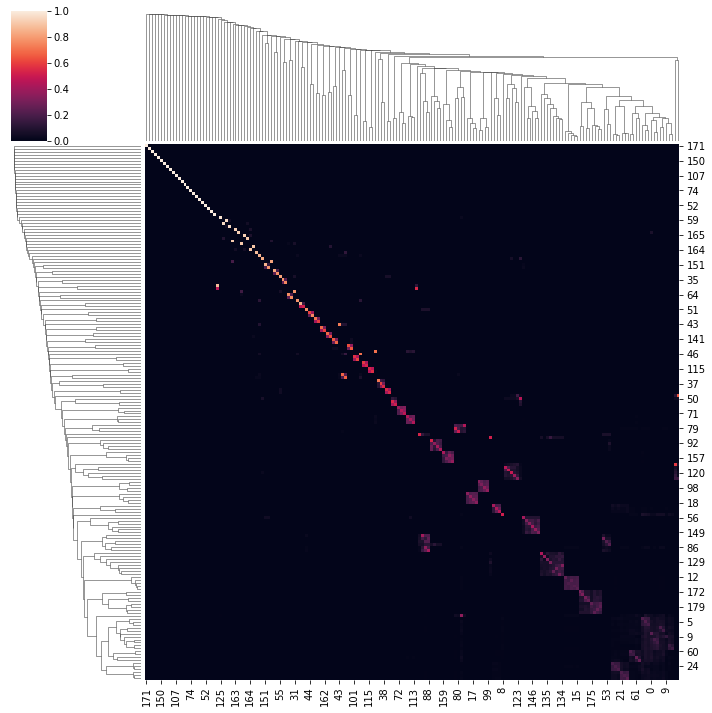

In [139]:
temp = pd.concat([agonists, antagonists],axis = 1)

temp = np.dot(temp, temp.T)
temp /= temp.sum(axis = 1)[:, None]
sns.clustermap(temp)

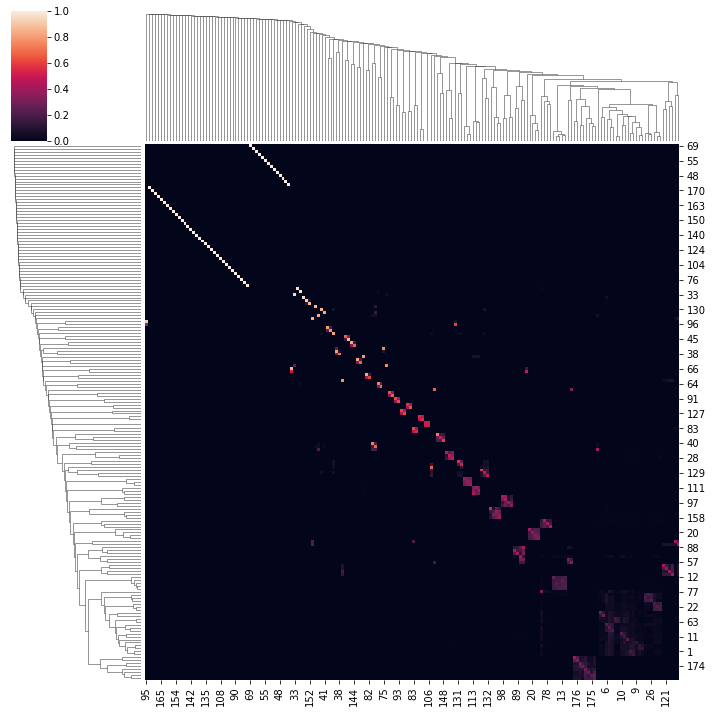

In [140]:

temp = np.dot(antagonists, antagonists.T)
temp /= temp.sum(axis = 1)[:, None]
sns.clustermap(temp)

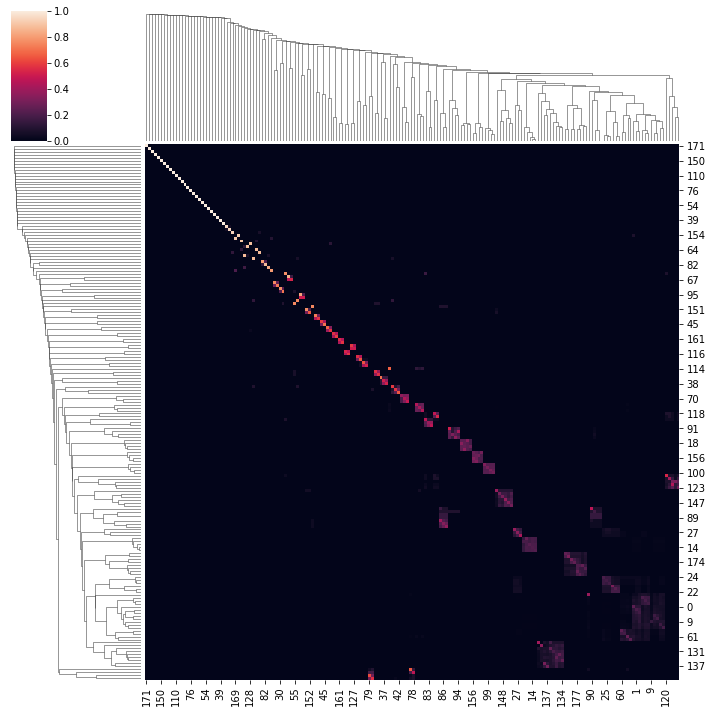

In [141]:

temp = np.dot(agonists, agonists.T)
temp /= temp.sum(axis = 1)[:, None]
sns.clustermap(temp)